In [108]:
import cv2
import cvzone
import numpy as np
import matplotlib.pyplot as plt

ground_color = None

img = cv2.imread("test1.webp")
if ground_color is None:
    ground_color = img[int(img.shape[0]/2) ,int(img.shape[1]/2)]
img_contours = img.copy()
dh, dw, _ = img.shape



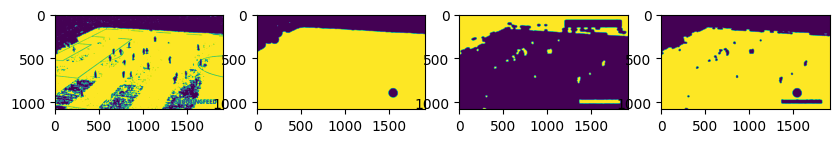

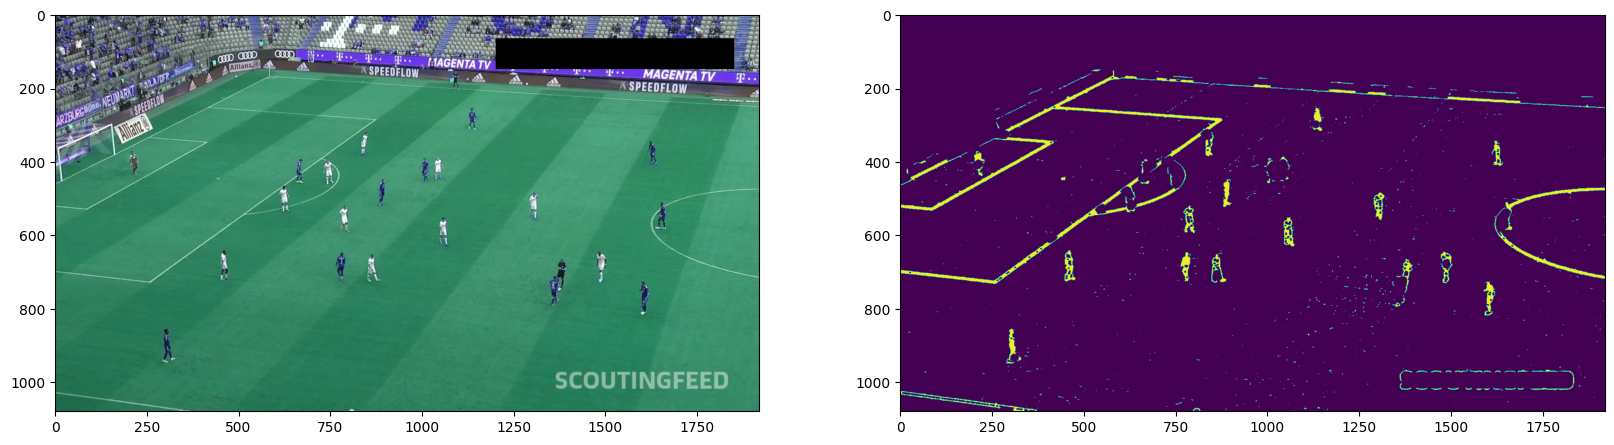

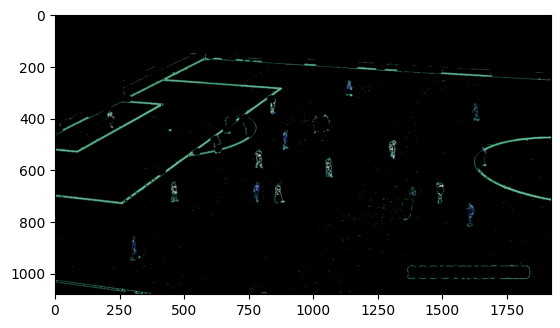

In [109]:

#converting into hsv image
hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

#hue histogram
#plt.hist(hsv[:,:,0].flatten(),bins=256)

#h_l,h_h = np.percentile(hsv[:,:,0],[20,80])
h_l,h_h = (40,90) # <- hand pick green partition of hsv
s_l,s_h = np.percentile(hsv[:,:,1],[10,90])
v_l,v_h = np.percentile(hsv[:,:,2],[5,95])

#green range
lower_green = np.array([h_l,s_l,v_l])
upper_green = np.array([h_h,s_h,v_h])

# define the base green mask
mask = cv2.inRange(hsv, lower_green, upper_green)


# define edge avere mask
adt_mask = cv2.adaptiveThreshold(gray,255,adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,thresholdType=cv2.THRESH_BINARY,blockSize=11,C=5)
# define edge avare inverted
adt_mask_inv  = cv2.bitwise_not(adt_mask)
# create viewer mask -> based on high frequency components of the mask, blurring the edge avera mask can generate a "noise" density map
avg_noise = cv2.blur(adt_mask_inv,(25,17))
viewer_mask = cv2.inRange(avg_noise,np.percentile(avg_noise,20)+1,255)
viewer_mask = cv2.erode(viewer_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,17)))
#remove holes
viewer_mask = cv2.erode(viewer_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(31,31)))
#under estimate mask size
viewer_mask = cv2.dilate(viewer_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(21,21)))


#compensate gaussian kernel
viewer_mask_inv = cv2.bitwise_not(viewer_mask)

#remove noise from the green mask
eroded_mask = cv2.erode(mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,5)))
#remove holes from the green mask based on morphologies
main_morph_mask_int = cv2.dilate(eroded_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(101,101)))
main_morph_mask = cv2.erode(main_morph_mask_int,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(92,96)))

#remove viewers from morph mask
field_mask = cv2.bitwise_and(main_morph_mask,viewer_mask_inv)
#remove holes again

#visuals
plt.figure(figsize=(10,3))
plt.subplot(141)
plt.imshow(mask)
plt.subplot(142)
plt.imshow(main_morph_mask)
plt.subplot(143)
plt.imshow(viewer_mask)
plt.subplot(144)
plt.imshow(field_mask)

#mask lines on the filed with the green mask == white lines on the footballfield, and players
composite_mask = cv2.bitwise_and(field_mask,adt_mask_inv)

#make the lines non edges
dilated_comp_mask = cv2.dilate(composite_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
composite_mask = cv2.erode(dilated_comp_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

#visuals
plt.figure( figsize=(20,10))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(composite_mask)

res = cv2.bitwise_and(img, img, mask=composite_mask)
res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
plt.figure()
plt.imshow(res)
img_blur = cv2.medianBlur(res_bgr ,5)
img_gray = cv2.cvtColor(img_blur ,cv2.COLOR_BGR2GRAY)



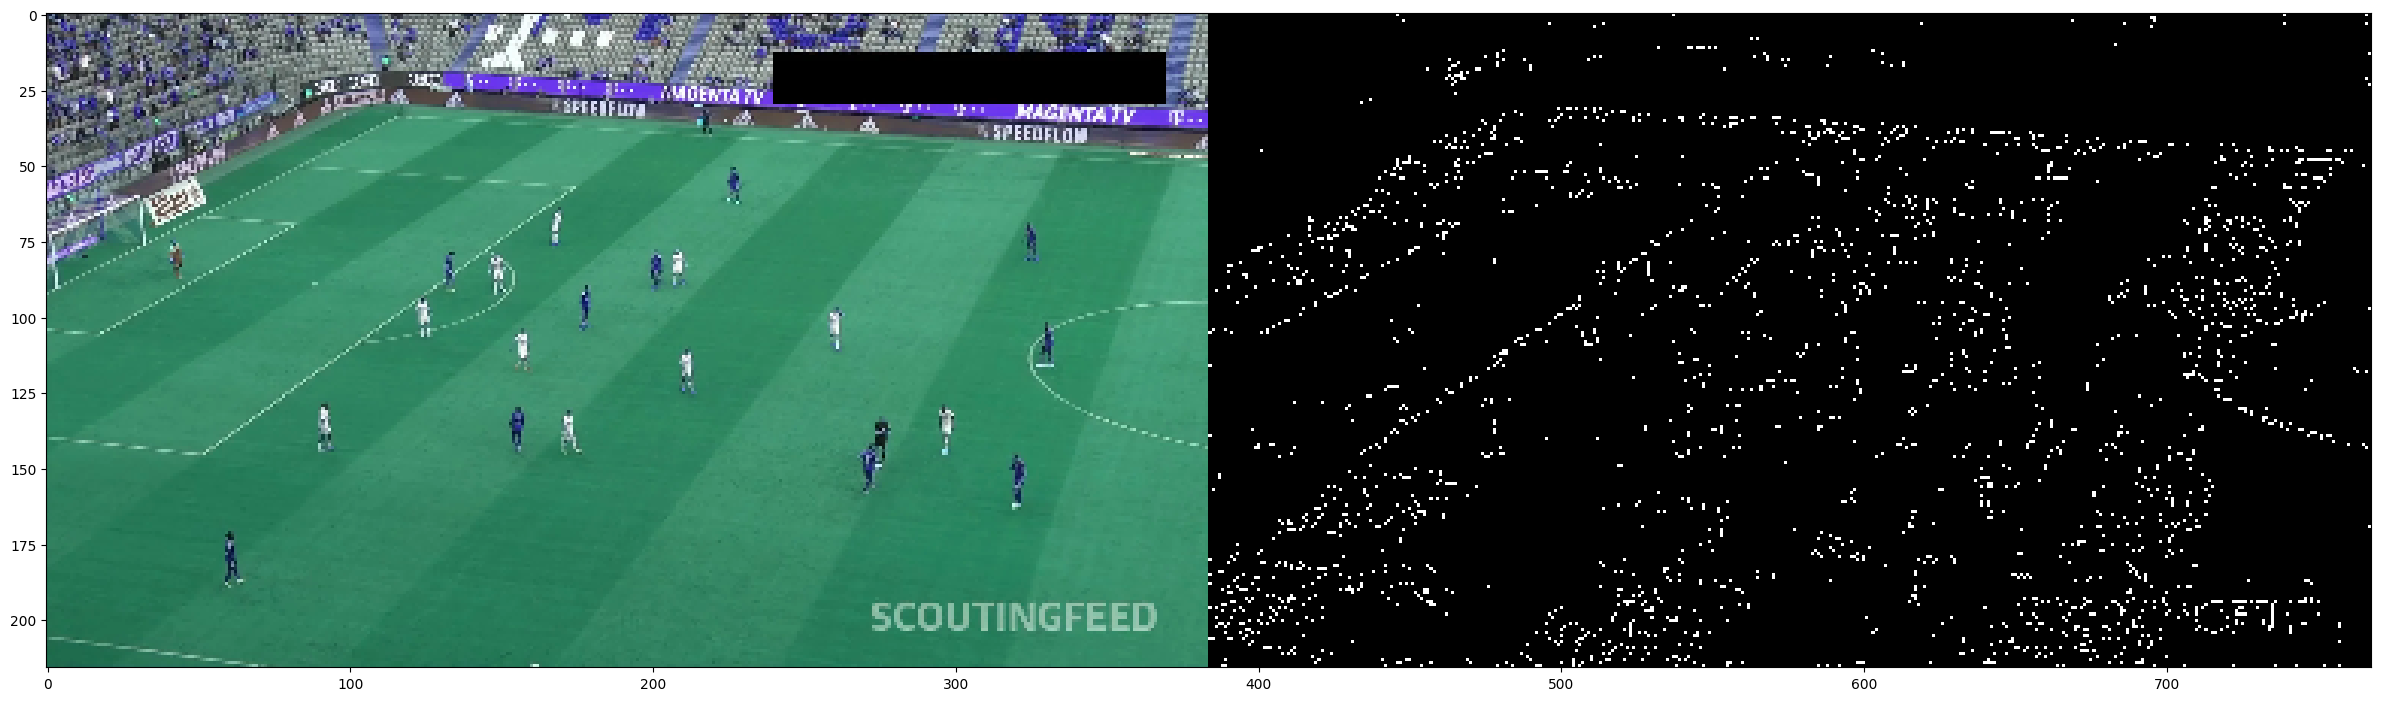

In [7]:
#threshold1 = cv2.getTrackbarPos("threshold1","Parameters")
# threshold2 = cv2.getTrackbarPos("threshold2","Parameters")
v = np.median(img_gray)
sigma = 0.33
#---- apply optimal Canny edge detection using the computed median----
lower_thresh = int(max(0, (1.0 - sigma) * v))
upper_thresh = int(min(255, (1.0 + sigma) * v))
# print(threshold1,threshold2)

img_canny = cv2.Canny(img_gray,lower_thresh,upper_thresh)

img_stack = cvzone.stackImages(([img,img_canny]) ,2,0.2)

plt.figure(figsize=(30,10))
plt.imshow(img_stack)